In [1]:
from importlib import reload
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import subprocess
from glob import glob
from pkg import *
from pkg.functions import convert2int, convert2str, get_params
from typing import List, Dict, Any
from torch.optim.lr_scheduler import ReduceLROnPlateau


In [2]:
datasets = [1, 4]

myPaths = path.PathManager(datasets=datasets)
myProcessor = process.Processor(paths=myPaths, datasets=datasets)
params = myProcessor.get_parameters()
print(params)
f.get_counts(paths=myPaths, datasets=datasets)

# myDatasetManager = data.DatasetManager(paths=myPaths, datasets=datasets)

# train_loader, test_loader = f.prepare(data_manager=myDatasetManager, batch_size=10)

Water backgrounds initialized: 0
{'01': {'clen': 0.15, 'photon_energy': 6000}, '04': {'clen': 0.25, 'photon_energy': 6000}}
Paths refreshed for dataset ['01', '04'].
Directory: peaks/01
	Total files: 58
	Normal images: 39
	Empty images: 19
Directory: labels/01
	Total files: 97
	Normal images: 78
	Empty images: 19
Directory: peaks_water_overlay/01
	Total files: 97
	Normal images: 78
	Empty images: 19
Directory: peaks/04
	Total files: 21
	Normal images: 14
	Empty images: 7
Directory: labels/04
	Total files: 35
	Normal images: 28
	Empty images: 7
Directory: peaks_water_overlay/04
	Total files: 35
	Normal images: 28
	Empty images: 7


In [3]:
f.check_attributes(paths=myPaths, datasets=f.convert2str(datasets), dir_type='peak')
print(myProcessor.get_parameters())

# f.retrieve_attributes(file_path=myPaths.total_paths.water_background[0])

c:\Users\ejsev\Desktop\cxls_hitfinder\images\peaks\01\empty_peak_01_00001.h5 conforms to expected attributes.
c:\Users\ejsev\Desktop\cxls_hitfinder\images\peaks\01\empty_peak_01_00001.h5:
Expected Peak: False, Actual Peak: False
c:\Users\ejsev\Desktop\cxls_hitfinder\images\peaks\01\empty_peak_01_00002.h5 conforms to expected attributes.
c:\Users\ejsev\Desktop\cxls_hitfinder\images\peaks\01\empty_peak_01_00002.h5:
Expected Peak: False, Actual Peak: False
c:\Users\ejsev\Desktop\cxls_hitfinder\images\peaks\01\empty_peak_01_00003.h5 conforms to expected attributes.
c:\Users\ejsev\Desktop\cxls_hitfinder\images\peaks\01\empty_peak_01_00003.h5:
Expected Peak: False, Actual Peak: False
c:\Users\ejsev\Desktop\cxls_hitfinder\images\peaks\01\empty_peak_01_00004.h5 conforms to expected attributes.
c:\Users\ejsev\Desktop\cxls_hitfinder\images\peaks\01\empty_peak_01_00004.h5:
Expected Peak: False, Actual Peak: False
c:\Users\ejsev\Desktop\cxls_hitfinder\images\peaks\01\empty_peak_01_00005.h5 conform

In [4]:
f.get_counts(paths=myPaths, datasets=datasets)
# %run process_directory.py ../../images  --percent_empty 0.5 

Paths refreshed for dataset ['01', '04'].
Directory: peaks/01
	Total files: 58
	Normal images: 39
	Empty images: 19
Directory: labels/01
	Total files: 97
	Normal images: 78
	Empty images: 19
Directory: peaks_water_overlay/01
	Total files: 97
	Normal images: 78
	Empty images: 19
Directory: peaks/04
	Total files: 21
	Normal images: 14
	Empty images: 7
Directory: labels/04
	Total files: 35
	Normal images: 28
	Empty images: 7
Directory: peaks_water_overlay/04
	Total files: 35
	Normal images: 28
	Empty images: 7


In [5]:
myDataManager = data.DatasetManager(paths=myPaths, datasets=datasets, transform=None)


train_loader, test_loader = f.prepare(data_manager=myDataManager, batch_size=10)

Actual percentage of empty images: 22.740524781341108% across peaks, water_overlays, and labels directories.

Final dataset sizes - Peaks: 79, Labels: 132, Overlays: 132

Data prepared.
Train size: 105
Test size: 27
Batch size: 10
Number of batches in train_loader: 11 



In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
optimizer = optim.Adam
scheduler = scheduler = ReduceLROnPlateau

cfg = {
    "loader": [train_loader, test_loader],
    'num_epochs': 15,
    'batch_size': train_loader.batch_size,
    'optimizer': optimizer,
    'device': device,
    'scheduler': scheduler
    }


peak_config = eval.Peak_Detection_Configuration(myPaths, datasets, device, save_path='../models/peak_model.pt')
print(f'weights for peak : {peak_config.get_loss_weights()}')
photon_config = eval.Photon_Energy_Configuration(myPaths, datasets, device, save_path='../models/photon_model.pt')
print(f'weights for photon energy : {photon_config.get_loss_weights()}')
clen_config = eval.Camera_Length_Configureation(myPaths, datasets, device, save_path='../models/clen_model.pt')
print(f'weights for camera length : {clen_config.get_loss_weights()}')

cuda
Paths refreshed for dataset ['01', '04'].
weights for peak : tensor([0.2453])
Paths refreshed for dataset ['01', '04'].
weights for photon energy : tensor([1.0000, 2.7714, 1.0000])
Paths refreshed for dataset ['01', '04'].
weights for camera length : tensor([1.0000, 2.7714, 1.0000])


In [7]:
# a = train_eval.TrainTestModels(cfg, peak_config)
# a.epoch_loop()
# a.plot_loss_accuracy()
# a.plot_confusion_matrix()
# a.get_confusion_matrix()
# a.save_model()

In [8]:
# b = train_eval.TrainTestModels(cfg, photon_config)
# b.epoch_loop()
# b.plot_loss_accuracy()
# b.plot_confusion_matrix()
# b.get_confusion_matrix()
# b.save_model()

In [9]:
# c = train_eval.TrainTestModels(cfg, clen_config)
# c.epoch_loop()
# c.plot_loss_accuracy()
# c.plot_confusion_matrix()
# c.get_confusion_matrix()
# c.save_model()

In [10]:

# reload(pipe)
# torch.cuda.synchronize()
# torch.cuda.empty_cache()
pipeline = pipe.ModelPipeline(peak_config, photon_config, clen_config, device)


Data prepared.
Train size: 105
Test size: 27
Batch size: 1
Number of batches in train_loader: 105 

-- attributes: {'clen': tensor([0.1500], dtype=torch.float64), 'peak': tensor([True]), 'photon_energy': tensor([6000])}
Tensor -> Numpy: [[[5. 4. 8. ... 5. 5. 8.]
  [4. 7. 6. ... 1. 3. 0.]
  [4. 5. 7. ... 8. 2. 4.]
  ...
  [4. 5. 6. ... 7. 3. 8.]
  [5. 3. 3. ... 3. 2. 7.]
  [2. 4. 6. ... 2. 5. 5.]]]
No data in region for coordinates [0 0 0] with radius 1
No data in region for coordinates [0 0 0] with radius 2
No data in region for coordinates [0 0 0] with radius 3
No data in region for coordinates [0 0 0] with radius 4
No data in region for coordinates [0 0 1] with radius 1
No data in region for coordinates [0 0 1] with radius 2
No data in region for coordinates [0 0 1] with radius 3
No data in region for coordinates [0 0 1] with radius 4
No data in region for coordinates [0 0 2] with radius 1
No data in region for coordinates [0 0 2] with radius 2
No data in region for coordinates [0 0

TypeError: eval() arg 1 must be a string, bytes or code object

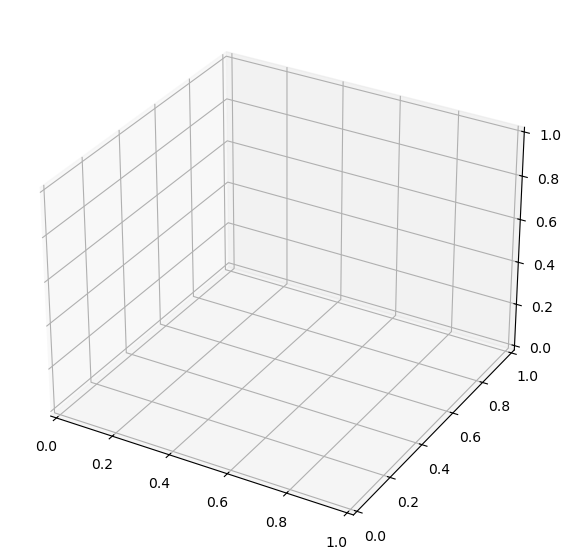

In [11]:
train_loader, test_loader = f.prepare(data_manager=myDataManager, batch_size=1)

for inputs, labels, attributes in train_loader:
    print(f'-- attributes: {attributes}')
    results = pipeline.run(inputs.to(device))
    print(f'-- results: {results}')
    break